# Preparación de ambiente

## Carga de módulos

!pip install varclushi
!pip install geopandas
!pip install geopy

In [1]:
##### BÁSICAS ######
import numpy as np
import pandas as pd

##### PIPELINE Y MODELO #####
#from xgboost.sklearn import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config

##### FEATURE SELECTION #####
from varclushi import VarClusHi
from sklearn.feature_selection import SelectKBest, f_classif

#### AUXILIARES #####
from geopy import distance
from datetime import datetime,timedelta
from tqdm.auto import tqdm
tqdm.pandas()
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent="myGeocoder")

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 50)
#set_config(display='diagram')

##### VISUALIZACIÓN #####
import cufflinks as cf
import matplotlib.pyplot as plt
cf.go_offline()

/home/abraxas/venv/DIPLOMADO/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Funciones relevantes

In [2]:
def tipo_datos(df):
    data = df.copy() 
    data['occurance'] = data.occurance.str.replace('24:00', '00:00')
    data['occurance'] = pd.to_datetime(data['occurance'], format='%m/%d/%Y %H:%M')
    data['report_date'] = pd.to_datetime(data['report_date'], format='%m/%d/%Y', errors='coerce')
    data['dseconds'] = pd.to_numeric(data['dseconds'], errors = 'coerce')
    data['dseconds'] = pd.to_numeric(data['dseconds'], errors = 'coerce')
    data['lat'] = pd.to_numeric(data['lat'], errors = 'coerce')
    data['long'] = pd.to_numeric(data['long'], errors = 'coerce')
    return data
def missings(df):
    data = df.copy()
    data.drop(data[data.duration.isnull()].index, inplace = True)
    data.drop(data[data.dseconds.isnull()].index, inplace = True)
    data.drop(data[data.lat.isnull()].index, inplace = True)
    data.drop(data[data.ufoshape.isnull()].index, inplace = True)
    data['country'] = data['country'].fillna('ND')
    data['citystate'] = data['citystate'].fillna('ND')
    data['description'] = data['description'].fillna('-')
    return data
def feature_engineering(df,cut_normalize:float=0.005):
    data = df.copy()
    data['country'] = data['country'].apply(lambda x: 'OTRO' if x in ['ca','gb','au','de'] else x)
    aux = (data.ufoshape.value_counts(1)<cut_normalize).to_frame()
    ls_ufoshape_normalize = aux[aux.ufoshape==True].index.tolist()
    data['ufoshape'] = data.ufoshape.apply(lambda x: 'unpopular' if x in ls_ufoshape_normalize else x)
    data['day_occ'] = data['occurance'].dt.day
    data['weekday_occ'] = data['occurance'].dt.weekday
    data['month_occ'] = data['occurance'].dt.month
    data['year_occ'] = data['occurance'].dt.year
    data['year_week_occ'] = data['occurance'].apply(lambda x: x.strftime('%Y-%W'))
    data['hour_occ'] = data.occurance.apply(lambda x: x.strftime('%H'))
    data['occurance'] = data['occurance'].apply(lambda x: datetime(x.year,x.month,x.day))
    data['days_toreport'] = list(map(lambda x,y: (x-y).days,data['report_date'],data['occurance']))
    data = data[data.days_toreport>=0].reset_index(drop=True).copy()
    data['n_words'] = data.description.apply(lambda x: len(x.split(' ')))
    data['n_letrers'] = data.description.apply(lambda x: len(x))
    return data
def get_bounds(x,q_down:float=0.05,q_up:float=0.95,factor:float=1.5):
    '''Obtener intervalo de aceptación para no considerar outliers'''
    q3 = x.quantile(q_up)
    q1 = x.quantile(q_down)
    iqr = q3 - q1
    lb = q1 - factor*iqr
    ub = q3 + factor*iqr
    return pd.Interval(lb, ub, closed="both")

def outliers(df,columnas_continuas:list=["dseconds","days_toreport"]):
    data = df.copy()
    dc_out = {feat: get_bounds(data[feat]) for feat in columnas_continuas}
    for col in columnas_continuas:
        data[f"ol_{col}"] = data[col].map(lambda x: x not in dc_out[col]).astype(int)
    data["ol"] = data[[x for x in data.columns if x.startswith("ol")]].mean(axis=1)
    data["ol"].describe([0.9, 0.95, 0.96, 0.97, 0.98, 0.99])
    data = data[data["ol"]<=0.3].drop(columns=[x for x in data.columns if x.startswith("ol")])
    return data 

def create_tad(df):
    data = df.copy()
    data['year_month_occ'] = data.occurance.apply(lambda x: x.strftime('%Y-%m'))
    agg_func = {'dseconds':['median','std'],'days_toreport':['median']}
    desc_columns = [x for x in data.columns if x.startswith('word')]
    agg_func.update(dict(zip(desc_columns,['sum']*len(desc_columns))))   
    ohe_fts = [x for x in data.columns if x.startswith('word') or x.startswith('country') or x.startswith('hour')]
    agg_func.update(dict(zip(ohe_fts,['sum']*len(ohe_fts))))   
    ohe_fts = [x for x in data.columns if x.startswith('month') or x.startswith('weekday')]
    agg_func.update(dict(zip(ohe_fts,['max']*len(ohe_fts))))   
    agg_func.update({'year_month_occ':['min','max']})
    tad = data.groupby(['year_week_occ','ufoshape']).agg(agg_func).reset_index()
    tad.columns = ['_'.join(x) if x[1]!='' else x[0] for x in tad.columns]
    primer_fecha = tad.year_month_occ_min.min()
    ultima_fecha = tad.year_month_occ_max.max()
    rango_fechas = pd.date_range(primer_fecha,ultima_fecha,freq='W').strftime('%Y-%W')
    tad.drop(columns=['year_month_occ_min','year_month_occ_max'],inplace=True)
    ls_dfs = []
    for shape in data.ufoshape.unique():
        aux = tad[tad.ufoshape==shape].copy()
        aux['y'] = 1
        aux_missing = pd.DataFrame({'year_week_occ':[x for x in rango_fechas if x not in aux.year_week_occ.tolist()]})
        if len(aux_missing)>0:
            aux_missing['y'] = 0
        aux = aux.append(aux_missing)
        aux['ufoshape'] = shape
        aux['y'] = aux['y'].shift(-1)
        aux.dropna(subset=['y'],inplace=True)
        aux[[x for x in aux.columns if x not in ['year_week_occ','ufoshape']]] = aux[[x for x in aux.columns if x not in ['year_week_occ','ufoshape']]].fillna(0)
        ls_dfs.append(aux)
    tad = pd.concat(ls_dfs,sort=False).sort_values(by=['ufoshape','year_week_occ']).reset_index(drop=True)
    tad.dropna(inplace=True)
    return tad,tad[['y']]

def escalamiento(df):
    data = df.copy()
    y = data[["y"]]
    mm = MinMaxScaler()
    X = data.drop(columns = ["y",'year_week_occ','ufoshape'], axis = 1)
    mm.fit(X)
    Xmm = pd.DataFrame(index = X.index, data = mm.transform(X), columns=X.columns) 
    return Xmm

def feature_selection(df,y,clusters:int=10,selection:str='kbest',n_features:int=20):
    print('Feature selection')
    data = df.copy()
    if selection == 'varclushi':
        vc = VarClusHi(df=data, feat_list=data.columns,maxclus=n_features)
        vc.varclus()
        res = vc.rsquare.sort_values(by=["Cluster", "RS_Ratio"]).groupby(["Cluster"]).first()
        bf = [x for x in res["Variable"]]
    elif selection == 'kbest':
        kb = SelectKBest(k="all")
        kb.fit(data, y)
        kb_scores = pd.DataFrame({'variable':data.columns,'score':kb.scores_})
        kb_scores = kb_scores.sort_values(by='score').reset_index(drop=True).dropna()
        bf = [x for x in kb_scores["variable"].tail(n_features)]
    return bf
def classification_metrics(X, y, model,pipe=None,scores:tuple=('roc_auc')):
    '''Medir performance del modelo'''
    if pipe:
        pipe = Pipeline(pipe.steps + [("model", model)])
    else:
        pipe = Pipeline([("model", model)])
    ls_scores = cross_val_score(estimator=pipe, X=X, y=y, scoring=scores, n_jobs=-1, cv=4)
    print(f"Media: {np.mean(ls_scores):,.2f}, STD: {np.std(ls_scores)}")
    

def hyperparam_logistic(X, y, pipe=None):
    if pipe:
        pipe = Pipeline(pipe.steps + [("model", LogisticRegression())])
    else:
        pipe = Pipeline([("model", LogisticRegression())])
    param_grid = {"model__penalty": ["l1", "l2"],
                "model__C": [x/100 for x in range(100)]+[0],
                "model__class_weight": ["balanced", None],
                "model__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }
    hp = RandomizedSearchCV(cv=4, 
                          param_distributions=param_grid,
                          n_iter=150,
                          scoring="roc_auc", 
                          verbose=10,
                          error_score=-1000, 
                          estimator=pipe, 
                          n_jobs=-1,
                          random_state=0)
    hp.fit(X=X, y = y)
    print(f"ROC: {hp.best_score_:,.2f}")
    return hp

def hyperparam_neural(X, y, pipe=None):
    if pipe:
        pipe = Pipeline(pipe.steps + [("model", MLPClassifier())])
    else:
        pipe = Pipeline([("model", MLPClassifier())])
    param_grid = {"model__hidden_layer_sizes": [(a,b,c,) for a in range(10,60,10) for b in range(10,60,10) for c in range(10,60,10)],
                "model__activation": ['logistic', 'tanh', 'relu'],
                "model__solver": ['lbfgs', 'sgd', 'adam'],
                "model__alpha": np.arange(0.01,1,0.01),
                "model__learning_rate": ['constant', 'invscaling', 'adaptive'],
                }
    hp = RandomizedSearchCV(cv=4, 
                          param_distributions=param_grid,
                          n_iter=150,
                          scoring="roc_auc", 
                          verbose=10,
                          error_score=-1000, 
                          estimator=pipe, 
                          n_jobs=-1,
                          random_state=0)
    hp.fit(X=X, y = y)
    print(f"ROC: {hp.best_score_:,.2f}")
    return hp

def hyperparam_svc(X, y, pipe=None):
    if pipe:
        pipe = Pipeline(pipe.steps + [("model", SVC())])
    else:
        pipe = Pipeline([("model", SVC())])
    param_grid = {"model__C": np.arange(0.1,2,0.1),
                "model__kernel": ['linear', 'rbf', 'sigmoid','poly'],
                "model__degree": range(2,5),
                "model__probability": [True],
                }
    hp = RandomizedSearchCV(cv=4, 
                          param_distributions=param_grid,
                          n_iter=150,
                          scoring="roc_auc", 
                          verbose=10,
                          error_score=-1000, 
                          estimator=pipe, 
                          n_jobs=-1,
                          random_state=0)
    hp.fit(X=X, y = y)
    print(f"ROC: {hp.best_score_:,.2f}")
    return hp

#### Visualizaciones

In [3]:
def bar_periods(df,columna,title):
    aux = df[columna].value_counts().to_frame().sort_index()
    plt.subplots(figsize=(18,8))
    plt.title(title)
    aux[columna].plot(kind='bar', color='violet')
    plt.xticks(rotation=90, fontsize=15)
    plt.show()

## Data Wrangling

### Lectura de datos

In [4]:
columns = ['occurance', 'city', 'citystate', 'country', 'ufoshape', 'dseconds', 'duration', 'description', 'report_date', 'lat','long']
ufo_data = pd.read_csv('../datos/ufo_data.csv', sep=',', names =columns, low_memory=False)
data = ufo_data.copy()
data = data.drop(0, axis=0)
data.head(5)

,occurance,city,citystate,country,ufoshape,dseconds,duration,description,report_date,lat,long
1,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.9411111
2,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
3,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
4,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.6458333
5,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.8036111


### Ingeniería de datos

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88875 entries, 1 to 88875
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   occurance    88875 non-null  object
 1   city         88679 non-null  object
 2   citystate    81356 non-null  object
 3   country      76314 non-null  object
 4   ufoshape     85757 non-null  object
 5   dseconds     88873 non-null  object
 6   duration     85772 non-null  object
 7   description  88749 non-null  object
 8   report_date  88875 non-null  object
 9   lat          88875 non-null  object
 10  long         88875 non-null  object
dtypes: object(11)
memory usage: 8.1+ MB


Se observan nulos entre las variables city-description

Además, todas las variables son tipo objeto

#### Transformación de tipo de dato

In [6]:
data_processing = data.copy() 
data_processing = tipo_datos(data_processing)

#### Valores ausentes (missings)

In [7]:
#data.isna().mean()
data_processing.isnull().sum()/data_processing.shape[0]

occurance     0.0000
city          0.0022
citystate     0.0846
country       0.1413
ufoshape      0.0351
dseconds      0.0001
duration      0.0349
description   0.0014
report_date   0.0022
lat           0.0022
long          0.0000
dtype: float64

In [8]:
data_processing = missings(data_processing)

* Borraremos la duración, dseconfs, latitud, longitud y ufoshape que vengan nulos
* Con el primer experimento podemos hacer una imputación de los hulos para ufo_shape
* Description, country y citystate se ponen como ND

In [9]:
data_processing.isnull().sum()/data_processing.shape[0]

occurance     0.0000
city          0.0000
citystate     0.0000
country       0.0000
ufoshape      0.0000
dseconds      0.0000
duration      0.0000
description   0.0000
report_date   0.0000
lat           0.0000
long          0.0000
dtype: float64

In [10]:
data_processing.shape[0]/data.shape[0]

0.9396118143459916

### Análisis Univariado Continuo

In [11]:
data_processing['dseconds'] = data_processing['dseconds'].astype(np.int32)

In [12]:
ls_cont = ["dseconds", "lat", "long"]

In [13]:
data_processing[ls_cont].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

,dseconds,lat,long
count,83508.0000,83508.0000,83508.0000
mean,7744.2503,37.4519,-85.0800
std,578875.3714,11.5071,41.1110
min,0.0000,-82.8628,-176.6581
1%,0.0000,-26.2109,-125.0000
5%,1.0000,25.9699,-122.5113
50%,180.0000,39.1961,-87.6500
95%,3600.0000,49.8833,0.0000
99%,14400.0000,55.2500,120.9711
max,97836000.0000,72.7000,178.4419


* Longitud y latitud están entre los rangos correctos (-180,180), (-90,90)

* Se observan valores 0 y muy grandes para dseconds
* Se obtienen variables por day, weekday, month and year

In [14]:
data_processing = feature_engineering(data_processing)

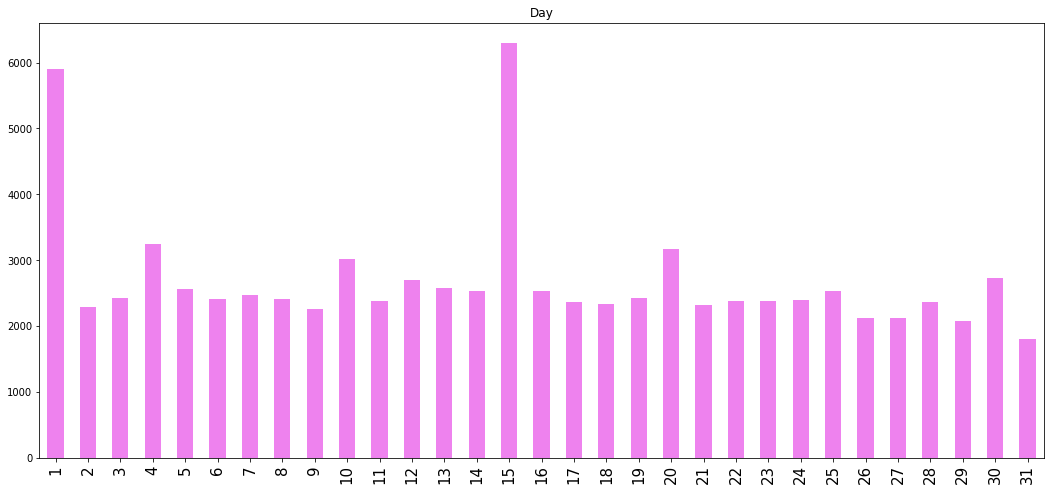

In [15]:
bar_periods(data_processing,'day_occ','Day')

Días del mes con más frecuencia 15

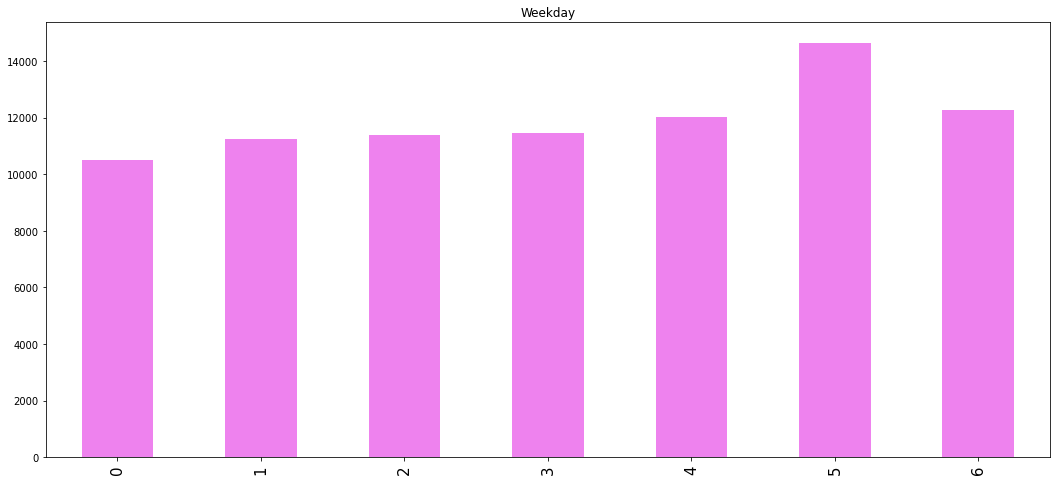

In [16]:
bar_periods(data_processing,'weekday_occ','Weekday')

Sábados es más frecuente

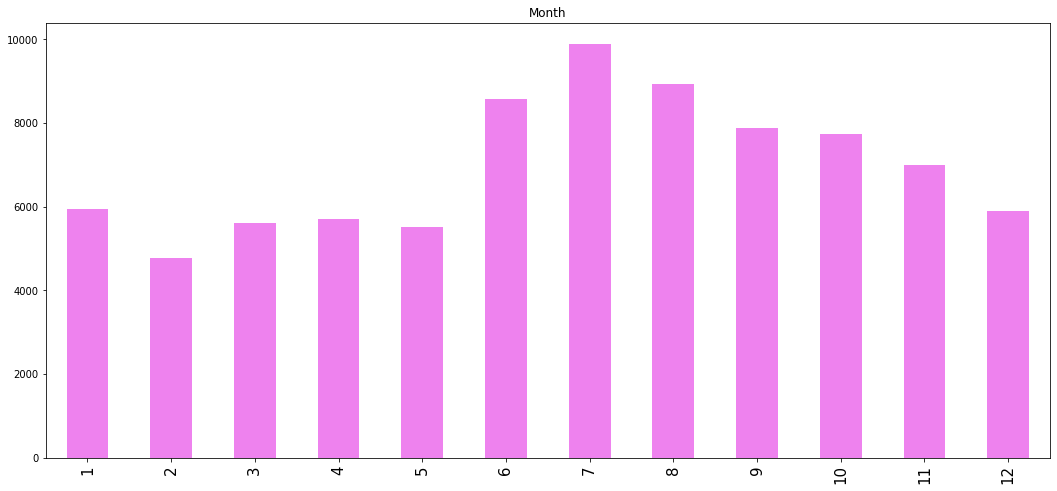

In [17]:
bar_periods(data_processing,'month_occ','Month')

En julio

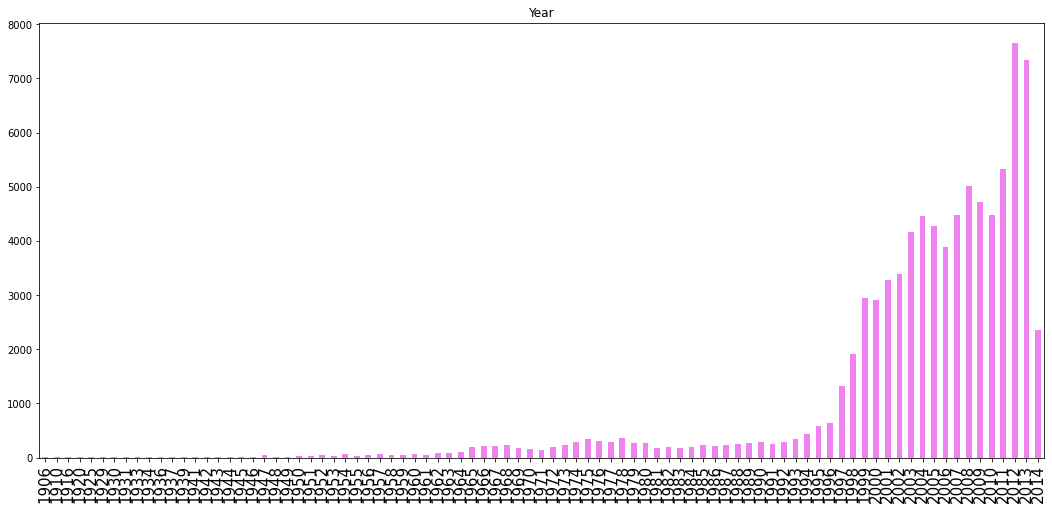

In [18]:
bar_periods(data_processing,'year_occ','Year')

Se han estado registrado cada vez más UFO

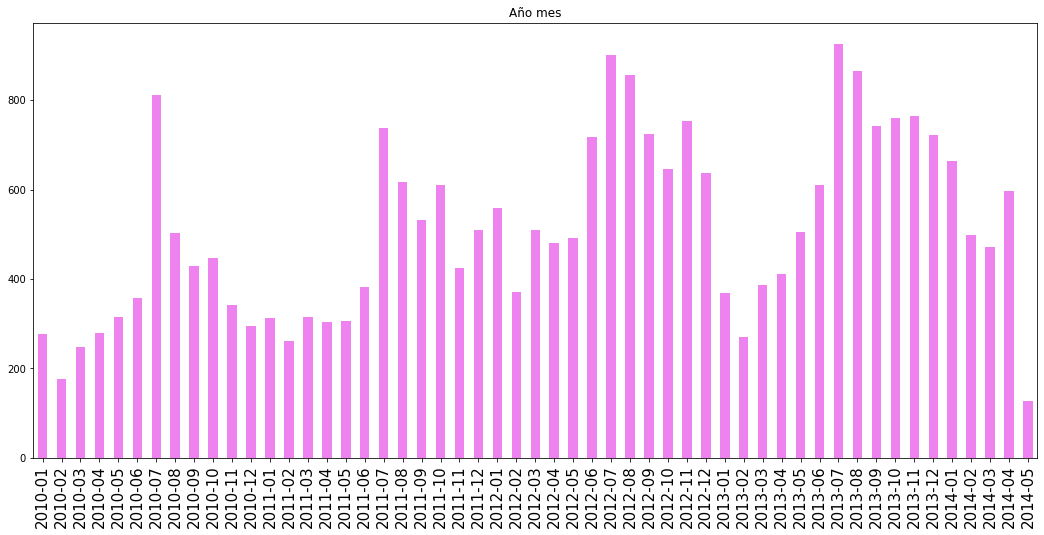

In [19]:
aux = data_processing.copy()
aux['year_month_occ'] = aux['occurance'].apply(lambda x: x.strftime('%Y-%m'))
aux = aux[aux.year_month_occ>='2010-01'].copy()
bar_periods(aux,'year_month_occ','Año mes')

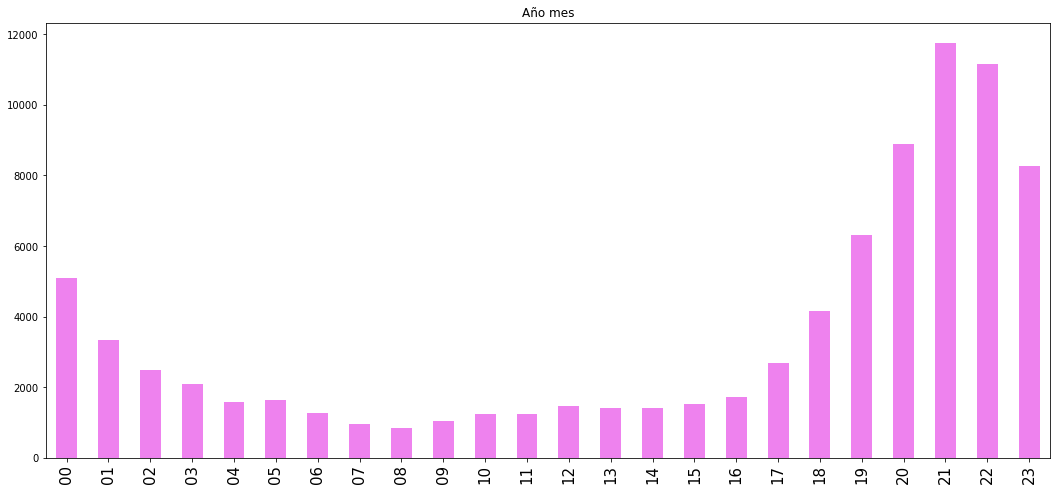

In [20]:
bar_periods(data_processing,'hour_occ','Año mes')

### Valores extremos (outliers)

In [21]:
data.columns

Index(['occurance', 'city', 'citystate', 'country', 'ufoshape', 'dseconds',
       'duration', 'description', 'report_date', 'lat', 'long'],
      dtype='object')

In [22]:
data_processing = outliers(data_processing)

Aquí notamos dseconds con outlier desde las secciones anteriores

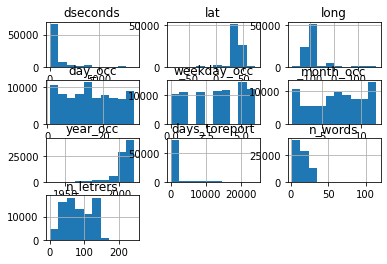

In [23]:
data_processing.hist();

### Análisis Univariado Discreto

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88875 entries, 1 to 88875
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   occurance    88875 non-null  object
 1   city         88679 non-null  object
 2   citystate    81356 non-null  object
 3   country      76314 non-null  object
 4   ufoshape     85757 non-null  object
 5   dseconds     88873 non-null  object
 6   duration     85772 non-null  object
 7   description  88749 non-null  object
 8   report_date  88875 non-null  object
 9   lat          88875 non-null  object
 10  long         88875 non-null  object
dtypes: object(11)
memory usage: 10.6+ MB


In [25]:
data.drop(columns=["city", "duration", "report_date"], inplace=True)

In [26]:
ls_disc = ["citystate", "country"]

In [27]:
for cat in ls_disc:
    print(f"***************{cat}**********")
    display(data[cat].value_counts(True))

***************citystate**********


ca   0.1284
wa   0.0572
fl   0.0565
tx   0.0498
ny   0.0432
      ...  
pe   0.0003
nt   0.0003
yt   0.0002
yk   0.0001
vi   0.0000
Name: citystate, Length: 68, dtype: float64

***************country**********


us   0.9211
ca   0.0428
gb   0.0269
au   0.0078
de   0.0015
Name: country, dtype: float64

In [28]:
#Country por latitud/longitud google api

In [29]:
data_processing['country'].value_counts()

us      65268
ND      11096
OTRO     5622
Name: country, dtype: int64

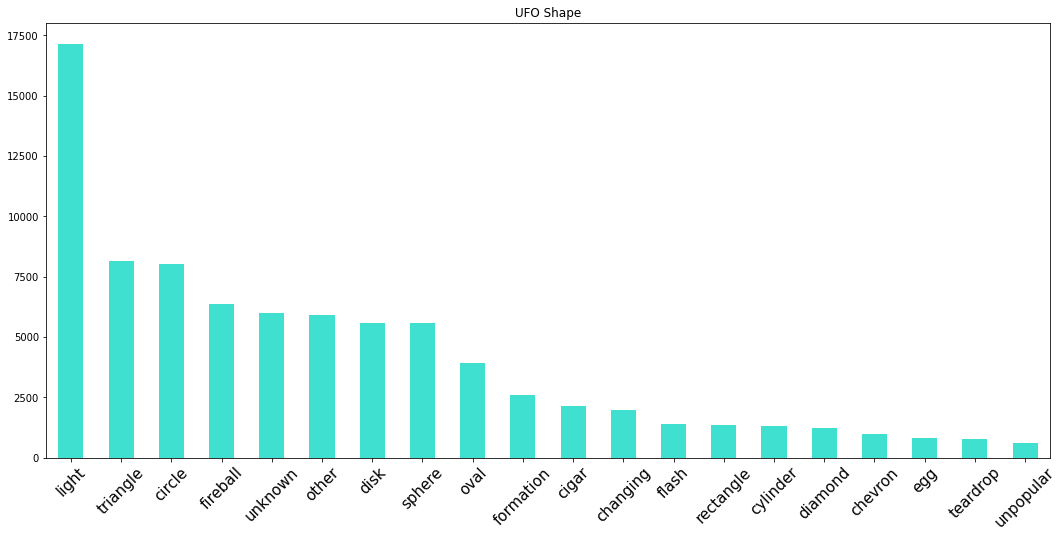

In [30]:
plt.subplots(figsize=(18,8))
plt.title("UFO Shape")
data_processing['ufoshape'].value_counts().plot(kind='bar', color='turquoise')
plt.xticks(rotation=45, fontsize=15)
plt.show()

Normalizamos las variable ufoshape

### Encoder de discretas

In [31]:
ls_disc = ['country','day_occ', 'weekday_occ', 'month_occ','hour_occ']

In [32]:
ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

In [33]:
ohe.fit(data_processing[ls_disc])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)

In [34]:
cols_ohe = [x.replace('x0','country') if x.startswith('x0') else x.replace('x1','day_occ') if x.startswith('x1') 
            else x.replace('x2','weekday_occ') if x.startswith('x2') else x.replace('x3','month_occ') if x.startswith('x3') else
            x.replace('x4','hour_occ') for x in ohe.get_feature_names()]

In [35]:
data_processing[ohe.get_feature_names()] = ohe.transform(data_processing[ls_disc])
data_processing.rename(columns=dict(zip(ohe.get_feature_names(),cols_ohe)), inplace=True)
data_processing[[x for x in cols_ohe if x not in data_processing.columns]] = 0
data_processing.drop(columns=ls_disc, inplace = True)

In [36]:
len(cols_ohe)

77

### Description

In [37]:
cv_description = CountVectorizer(stop_words=stopwords.words("english"), ngram_range=(1, 1), min_df=1, max_features=100)
cv_description.fit(data_processing["description"])
desc = pd.DataFrame(data=cv_description.transform(data_processing["description"]).todense(), columns=[f"word_{x}" for x in cv_description.get_feature_names()])
data_processing = data_processing.reset_index().join(desc)
data_processing.drop([ 'description','index'], axis=1, inplace=True)

In [38]:
ls_unary = [x for x, y in data.apply(lambda x: x.nunique()).items() if y == 1]
ls_unary

[]

# TAD

## Crear variable objetivo

In [39]:
tad,y = create_tad(data_processing)

n_weeks = 12
data_aux[f'occur_{n_weeks}sem'] = [rango_km(data_aux,fecha,latitud,longitud,n_weeks=n_weeks) for latitud,longitud,fecha in
                              tqdm(zip(data_aux.lat,data_aux.long,data_aux.year_month))]

import time
import multiprocessing

if __name__ == '__main__':
    starttime = time.time()
    processes = []
    for latitud,longitud,fecha in tqdm(zip(data_aux.lat,data_aux.long,data_aux.year_month)):
        p = multiprocessing.Process(target=rango_km, args=(data_aux,fecha,latitud,longitud,n_weeks))
        processes.append(p)
        p.start()
        
    for process in processes:
        process.join()
        
    print()    
    print('Time taken = {} seconds'.format(time.time() - starttime))

In [40]:
y.y.value_counts(1)

0.0000   0.7432
1.0000   0.2568
Name: y, dtype: float64

## Escalamiento

In [41]:
Xmm = escalamiento(tad)

In [42]:
y.y.value_counts(1)

0.0000   0.7432
1.0000   0.2568
Name: y, dtype: float64

## Seleccionar variable

### Multicolinealidad

No trabaja con muchas variables

vc = VarClusHi(df=Xmm, feat_list=Xmm.columns,maxclus=10)

vc.varclus()

res = vc.rsquare.sort_values(by=["Cluster", "RS_Ratio"]).groupby(["Cluster",'Variable']).first()

res_aux = res.reset_index()

res = vc.rsquare.sort_values(by=["Cluster", "RS_Ratio"]).groupby(["Cluster"]).first()

bf = [x for x in res["Variable"]]

bf

Xv = X[bf]

### KBest

In [43]:
bf = feature_selection(Xmm,y)

Feature selection


/home/abraxas/venv/DIPLOMADO/lib/python3.8/site-packages/sklearn/utils/validation.py:744: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [44]:
Xv = Xmm[bf].copy()

# Modelos

In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import r2_score, mean_absolute_error, roc_auc_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, LogisticRegression, Lars, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor, SGDClassifier

In [46]:
X_train, X_test, y_train, y_test = train_test_split(Xv, y, test_size=0.3, random_state=777)

In [47]:
print(y_train.y.value_counts(1),y_test.y.value_counts(1))

0.0000   0.7442
1.0000   0.2558
Name: y, dtype: float64 0.0000   0.7407
1.0000   0.2593
Name: y, dtype: float64


## Regresión logística

In [48]:
logreg = LogisticRegression()

In [50]:
hp_logistic = hyperparam_logistic(X_train,y_train)

Fitting 4 folds for each of 150 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1538s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.3238s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    9.4s
[Parallel(n_j

ROC: 1.00


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   21.8s finished
/home/abraxas/venv/DIPLOMADO/lib/python3.8/site-packages/sklearn/utils/validation.py:744: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [51]:
be_logistic = hp_logistic.best_estimator_.steps[0][1]

In [52]:
roc_auc_score(y_train,be_logistic.predict(X_train))

0.9998108076149935

In [53]:
roc_auc_score(y_test,be_logistic.predict(X_test))

0.9998891229626344

pipe = Pipeline([("im", SimpleImputer(strategy="median")), ("sc", MinMaxScaler()), ("kb", SelectKBest(k=42, score_func=f_classif))])

### Red neuronal

In [103]:
rn =  MLPClassifier()

In [104]:
classification_metrics(X_train, y_train,rn)

ROC media: 1.00, desviación estándar: 0.0


In [106]:
hp_neural = hyperparam_neural(X_train, y_train)or x.startswith('month') 

Fitting 4 folds for each of 150 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

ROC: 1.00


In [107]:
be_neural = hp_neural.best_estimator_.steps[0][1]

In [110]:
roc_auc_score(y_test,be_logistic.predict(X_test))

0.9977303070761014

### Support Vector Machine

In [114]:
classification_metrics(X_train, y_train,SVC())

ROC media: 1.00, desviación estándar: 0.0


In [115]:
hp_svc = hyperparam_svc(X_train, y_train)

Fitting 4 folds for each of 150 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

KeyboardInterrupt: 

In [ ]:
hp_svc.score(X_test, y_test)

### XGBoost

In [ ]:
classification_metrics(X_train, y_train, pipe, XGBClassifier())

In [ ]:
xgb = XGBClassifier()

In [ ]:
xgb.fit(X_train, y_train)

In [ ]:
xgb.score(X_test, y_test)

## Resultados

In [ ]:
proba_logistic_train = hp_logistic.predict_proba(X_train)
proba_neural_train = hp_neural.predict_proba(X_train)
proba_svc_train = hp_svc.predict_proba(X_train)
proba_xgb_train = xgb.predict_proba(X_train)

In [ ]:
proba_logistic_test = hp_logistic.predict_proba(X_test)
proba_neural_test = hp_neural.predict_proba(X_test)
proba_svc_test = hp_svc.predict_proba(X_test)
proba_xgb_test = xgb.predict_proba(X_test)

In [ ]:
X_train["proba_logistic"] = proba_logistic_train[:, 1]
X_train["proba_neural"] = proba_neural_train[:, 1]
X_train["proba_svc"] = proba_svc_train[:, 1]
X_train["proba_xgb"] = proba_xgb_train[:, 1]
X_train["set"] = "train"

In [ ]:
X_test["proba_logistic"] = proba_logistic_test[:, 1]
X_test["proba_neural"] = proba_neural_test[:, 1]
X_test["proba_svc"] = proba_svc_test[:, 1]
X_test["proba_xgb"] = proba_xgb_test[:, 1]
X_test["set"] = "test"

In [ ]:
for tabla in X_train, X_test:
    for modelo in ["logistic", "neural", "svc", "xgb"]:
        tabla[f"bin_proba_{modelo}"] = pd.cut(tabla[f"proba_{modelo}"],bins=np.arange(0,1.1,0.1),include_lowest=True).astype(str)

In [ ]:
full = pd.concat([X_train.join(y_train), X_test.join(y_test)])

In [ ]:
full.to_pickle("full_loan.diplo")

In [ ]:
full[[x for x in full.columns if x.startswith("proba") or x.startswith("bin_proba")]+["tgt", "set"]].to_csv("full_loan.csv")